# **MODEL BUILDING**

In [ ]:
!pip install numpy==1.26.4, tensorflow==2.17.0

In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split



In [ ]:
def preprocess_data(data_path):
    df = pd.read_csv(data_path)

    nutrient_columns = ['Vitamin_A_mg', 'Vitamin_C_mg', 'Calcium_mg', 'Iron_mg']
    X = df.drop(nutrient_columns + ['Diet_Score'], axis=1)
    y = df[nutrient_columns]

    categorical_cols = ['Gender', 'Physical_Activity_Level', 'Smoking_Status',
                        'Alcohol_Intake', 'Chronic_Disease', 'Blood_Pressure',
                        'Cholesterol_Level', 'Income_Level', 'Education_Level', 'Occupation']

    numerical_cols = [col for col in X.columns if col not in categorical_cols]

    numerical_transformer = MinMaxScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    return X, y, preprocessor, nutrient_columns


In [ ]:
def build_model(input_dim, output_dim=4):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(output_dim)
    ])

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    return model

In [ ]:
# Function to train the model
def train_nutrient_model(X, y, preprocessor, batch_size=64, epochs=60):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Preprocess the data
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Get input dimension after preprocessing
    input_dim = X_train_processed.shape[1]
    output_dim = y_train.shape[1]

    # Build model
    model = build_model(input_dim, output_dim)

    # Callbacks for better training
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001
    )

    # Train the model
    history = model.fit(
        X_train_processed, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Evaluate model
    test_loss, test_mae = model.evaluate(X_test_processed, y_test)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test MAE: {test_mae:.4f}")

    # Calculate MAE for individual nutrients
    y_pred = model.predict(X_test_processed)
    individual_maes = np.mean(np.abs(y_pred - y_test.values), axis=0)

    return model, preprocessor, history, individual_maes


In [ ]:
# Function for inference on new data
def predict_nutrients(model, preprocessor, new_data, nutrient_columns):
    # Ensure new_data is a DataFrame
    if not isinstance(new_data, pd.DataFrame):
        new_data = pd.DataFrame([new_data])

    # Apply the same preprocessing
    processed_data = preprocessor.transform(new_data)

    # Make predictions
    predictions = model.predict(processed_data)

    # Create DataFrame with predictions
    predictions_df = pd.DataFrame(predictions, columns=nutrient_columns)

    return predictions_df


In [ ]:

# Main function to run the entire pipeline
def main(data_path, save_model=True):
    print("Loading and preprocessing data...")
    X, y, preprocessor, nutrient_columns = preprocess_data(data_path)

    print("Training model...")
    model, preprocessor, history, individual_maes = train_nutrient_model(X, y, preprocessor)

    # Print individual nutrient MAEs
    for i, nutrient in enumerate(nutrient_columns):
        print(f"MAE for {nutrient}: {individual_maes[i]:.4f}")

    if save_model:
        print("Saving model and preprocessor...")
        # Save with TensorFlow's SavedModel format
        model.save('nutrient_model.keras')
        import joblib
        joblib.dump(preprocessor, 'nutrient_preprocessor.pkl')
        joblib.dump(nutrient_columns, 'nutrient_columns.pkl')
        print("Model and preprocessor saved successfully.")

    # Example inference
    print("\nPerforming example inference...")
    example_person = pd.DataFrame([{
        'Age': 35,
        'Gender': 'Female',
        'Weight_kg': 65,
        'Height_cm': 165,
        'BMI': 23.8,
        'Physical_Activity_Level': 'High',
        'Sleep_Hours': 8,
        'Smoking_Status': 'No',
        'Alcohol_Intake': 'Occasional',
        'Daily_Calorie_Intake': 2200,
        'Meal_Frequency': 4,
        'Protein_Intake_g': 85,
        'Carbohydrate_Intake_g': 200,
        'Fat_Intake_g': 70,
        'Chronic_Disease': 'None',
        'Blood_Pressure': 'Normal',
        'Cholesterol_Level': 'Low',
        'Income_Level': 'Medium',
        'Education_Level': 'Master',
        'Occupation': 'Engineer'
    }])

    predictions = predict_nutrients(model, preprocessor, example_person, nutrient_columns)
    print("Predicted nutrients:")
    print(predictions)

    return model, preprocessor, nutrient_columns


In [ ]:
# Function to load saved model and make predictions
def load_and_predict(model_path, preprocessor_path, columns_path, new_data):
    # Load model and preprocessor
    model = tf.keras.models.load_model(model_path)
    preprocessor = joblib.load(preprocessor_path)
    nutrient_columns = joblib.load(columns_path)

    # Make predictions
    return predict_nutrients(model, preprocessor, new_data, nutrient_columns)


In [ ]:
# Example usage:
if __name__ == "__main__":
    # Path to your dataset with 10,000 entries
    data_path = 'nutrient_prediction_dataset.csv'

    # Train model and save
    model, preprocessor, nutrient_columns = main(data_path)

Loading and preprocessing data...
Training model...
Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 273084.3438 - mean_absolute_error: 276.6408 - val_loss: 267279.8438 - val_mean_absolute_error: 273.8501 - learning_rate: 1.0000e-04
Epoch 2/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 271783.2188 - mean_absolute_error: 276.1229 - val_loss: 266989.0625 - val_mean_absolute_error: 273.5569 - learning_rate: 1.0000e-04
Epoch 3/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 270712.3438 - mean_absolute_error: 275.3519 - val_loss: 266639.7500 - val_mean_absolute_error: 273.2624 - learning_rate: 1.0000e-04
Epoch 4/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 273105.0938 - mean_absolute_error: 276.2788 - val_loss: 265960.7500 - val_mean_absolute_error: 272.7581 - learning_rate: 1.0000e-04
Epoch 5/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 267926.3438 - mean_absolute_error: 273.8885 - val_loss: 264965.2500 - val_mean_absolute_error: 271.9885 - learning_rate: 1.0000e-04
Epoch 6/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

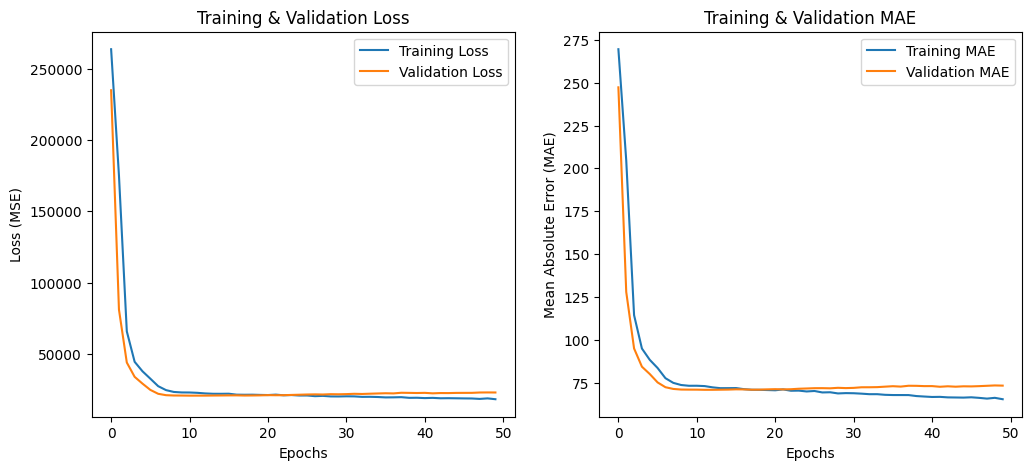

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training & Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training & Validation MAE')
plt.legend()

plt.show()


In [ ]:
print(tf.__version__)

2.17.0


In [ ]:
print(joblib.__version__)

1.4.2


In [ ]:
import sklearn

print(sklearn.__version__)

1.6.1


In [ ]:
!pip show numpy

Name: numpy
Version: 1.26.4
Summary: Fundamental package for array computing in Python
Home-page: https://numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: Copyright (c) 2005-2023, NumPy Developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are
met:

    * Redistributions of source code must retain the above copyright
       notice, this list of conditions and the following disclaimer.

    * Redistributions in binary form must reproduce the above
       copyright notice, this list of conditions and the following
       disclaimer in the documentation and/or other materials provided
       with the distribution.

    * Neither the name of the NumPy Developers nor the names of any
       contributors may be used to endorse or promote products derived
       from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYR

In [ ]:
!pip show pandas

Name: pandas
Version: 2.2.2
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: 
Author-email: The Pandas Development Team <pandas-dev@python.org>
License: BSD 3-Clause License

Copyright (c) 2008-2011, AQR Capital Management, LLC, Lambda Foundry, Inc. and PyData Development Team
All rights reserved.

Copyright (c) 2011-2023, Open source contributors.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be u